# Analysis of libjpeg - DCT

**Author:** Martin Beneš

This notebook contains forensic analysis of DCT method parameters in various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [33]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']

# default versions
import jpeglib
v_arbitrary = '7' # arbitrary version for compression
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 10

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

# dct methods to test
dct_methods = [dct for dct in jpeglib.DCTMethod.J_DCT_METHOD().keys() if dct is not None]
dct_methods

['JDCT_ISLOW', 'JDCT_IFAST', 'JDCT_FLOAT']

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [34]:
# list BOSS database
import os
boss_path = db_path / 'BOSS_raw' / 'BOSS_from_raw'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
#import cv2
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
import cv2
boss = np.array([np.array(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/nora/Datasets/BOSS_raw/BOSS_from_raw'

## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [35]:
# Load ALASKA2 database
import os
import random
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

# choose most and least saturated
import matplotlib.pyplot as plt
#most,least = (None,0),(None,0)
#for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)
    
print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80010 images.
Input shape (15, 256, 256, 3)


## Impact on decompression

First we evaluate for different `dct_method` in decompression.

In [36]:
# iterate all versions
import tempfile
images_rgb = {v: {} for v in versions}
images_Y = {v: {} for v in versions}
images_Cb = {v: {} for v in versions}
images_Cr = {v: {} for v in versions}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate decompression dct method
    for i,dct_method in enumerate(dct_methods):
            
            # evaluate for all the versions
            for v_decompress in versions:
                
                # compress each image with arbitrary dct method
                with jpeglib.version(v_arbitrary):
                    fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
                    for i,fname in enumerate(fnames):
                        im = jpeglib.from_spatial(alaska[i])
                        im.samp_factor = ((1,1),(1,1),(1,1))
                        im.write_spatial(fname, qt=75)

                # decompress each image with all dct methods
                with jpeglib.version(v_decompress):
                    images_rgb[v_decompress][dct_method] = np.array([
                        jpeglib.read_spatial(fname, dct_method=dct_method).spatial for fname in fnames
                    ])
                    images_Y[v_decompress][dct_method] = np.array([
                        jpeglib.read_dct(fname).Y for fname in fnames
                    ])
                    images_Cb[v_decompress][dct_method] = np.array([
                        jpeglib.read_dct(fname).Cb for fname in fnames
                    ])
                    images_Cr[v_decompress][dct_method] = np.array([
                        jpeglib.read_dct(fname).Cr for fname in fnames
                    ])

DCT method set to decompression does not change anything

## DCT method artifacts

We shall take a look in particular in the difference images between JPEGs compressed with different DCT methods.

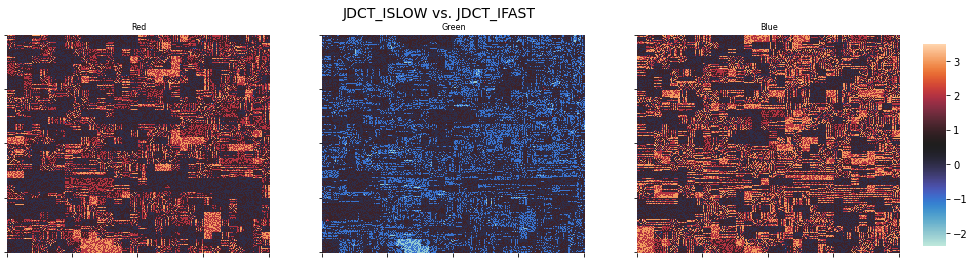

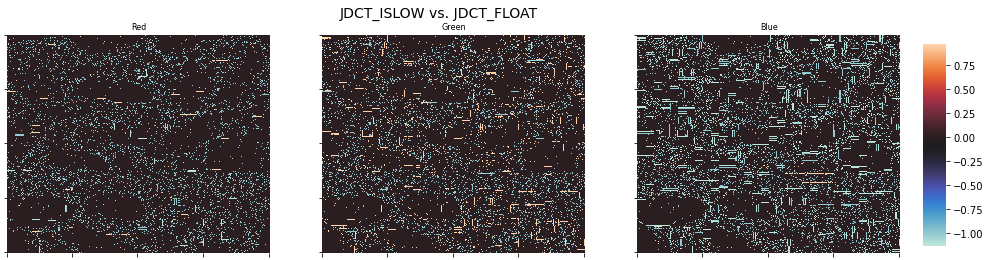

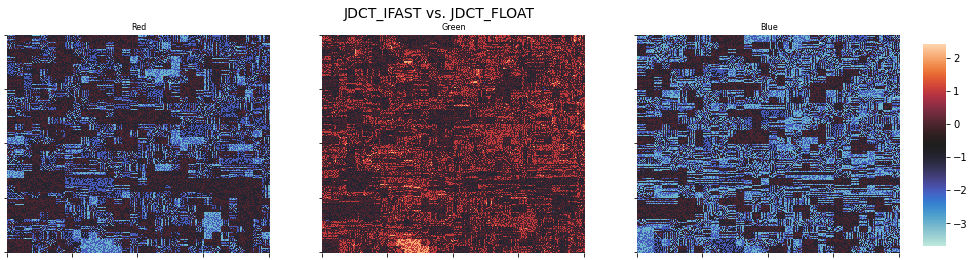

In [37]:
# difference metric
mismatch = lambda x1,x2: (x1.astype(np.float32) - x2.astype(np.float32))

# iterate all combinations of dct methods
for i,dct1 in enumerate(dct_methods):
    for dct2 in dct_methods[i+1:]:

        # difference
        D = mismatch(images_rgb['6b'][dct1], images_rgb['6b'][dct2])
        
        # plots
        import seaborn as sns
        fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
        cbar_ax = fig.add_axes([.92, .15, .02, .7])
        vmin,vmax = D.mean() - 3*D.std(), D.mean() + 3*D.std() # three sigma
        for i,(ax,title) in enumerate(zip(axs.flat,['Red','Green','Blue'])):
            p = sns.heatmap(D[0,:,:,i], cbar=i==0, vmin=vmin, vmax=vmax,
                            cmap=sns.color_palette("icefire", as_cmap=True),
                            ax=ax, cbar_ax=None if i else cbar_ax)
            p.set_xticks([0,63,127,191,255])
            p.set_yticks([0,63,127,191,255])
            p.set_title(title, fontsize=8)
        fig.suptitle(f'{dct1} vs. {dct2}', fontsize=14)
        #plt.savefig(f'{dct1}_{dct2}.png', dpi=600)

Let's visualize the distribution of the differences (over all channels).

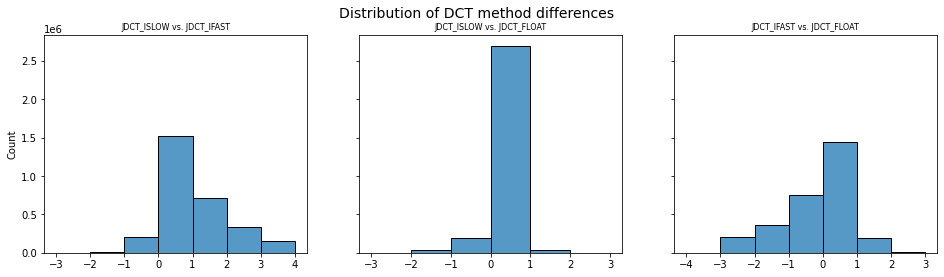

In [38]:
# plots
fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
fig.suptitle(f'Distribution of DCT method differences', fontsize=14)
it = 0

# iterate all combinations of dct methods
for i,dct1 in enumerate(dct_methods):
    for dct2 in dct_methods[i+1:]:

        # difference
        D = mismatch(images_rgb['6b'][dct1], images_rgb['6b'][dct2])
        
        # plots
        p = sns.histplot(D.flatten(), binwidth=1, ax=axs[it])
        p.set_title(f'{dct1} vs. {dct2}', fontsize=8)
        it += 1

# save figure
#plt.savefig(f'distr_dct_diff.png', dpi=600)

## Colored with downsampling

In [39]:
# images recompressed by each version
images_rgb_samp = {'version': [], 'dct_method': [], 'Y': [], 'Cb': [], 'Cr': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate dct methods
    for dct_method in dct_methods:
    
        # iterate versions
        for i,v_decompress in enumerate(versions):
    
            # compress with single (arbitrary) version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_arbitrary):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.samp_factor = ((2,2),(1,1),(1,1))
                    im.write_spatial(fname, qt=75)
        
            # decompress with each version
            with jpeglib.version(v_decompress):
                images_rgb_samp['version'].append(v_decompress)
                images_rgb_samp['dct_method'].append(dct_method)
                images_rgb_samp['image'].append(np.array([
                    jpeglib.read_spatial(fname, dct_method=dct_method, flags=['+DO_FANCY_SAMPLING']).spatial for fname in fnames
                ]))
                images_rgb_samp['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_rgb_samp['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb_samp['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])

# dataframe
import pandas as pd
images_rgb_samp = pd.DataFrame(images_rgb_samp)

### N-to-N comparison

In [40]:
# distance metric
from scipy.spatial.distance import pdist, squareform
pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

def get_distmat_dct(dct):
    # images to distance matrix
    images_dct_list = np.array([list(i) for i in dct.to_list()], dtype=object)
    images_dct_list = images_dct_list.reshape(len(versions), -1)
    dists_dct = pdist(images_dct_list, pixel_mismatch)
    distmat_dct = squareform(dists_dct)
    return distmat_dct

# images to distance matrix
distmats_rgb_samp = {}
distmats_Y_samp = {}
distmats_Cb_samp = {}
distmats_Cr_samp = {}
for dct_method in dct_methods:
    images_rgb_samp_dct = images_rgb_samp[images_rgb_samp.dct_method == dct_method]
    
    images_rgb_samp_list = np.array([list(i) for i in images_rgb_samp_dct.image.to_list()])
    images_rgb_samp_list = images_rgb_samp_list.reshape(len(versions), -1)
    dists_rgb_samp = pdist(images_rgb_samp_list, pixel_mismatch)
    distmat_rgb_samp = squareform(dists_rgb_samp)
    distmats_rgb_samp[dct_method] = distmat_rgb_samp

    distmats_Y_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Y)
    distmats_Cb_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Cb)
    distmats_Cr_samp[dct_method] = get_distmat_dct(images_rgb_samp_dct.Cr)

    # check match with spatial
    print(dct_method)
    print('-', ((distmat_rgb_samp != 0) == (distmats_Y_samp[dct_method] != 0)).all())
    print('-', ((distmat_rgb_samp != 0) == (distmats_Cb_samp[dct_method] != 0)).all())
    print('-', ((distmat_rgb_samp != 0) == (distmats_Cr_samp[dct_method] != 0)).all())

JDCT_ISLOW
- False
- False
- False
JDCT_IFAST
- False
- False
- False
JDCT_FLOAT
- False
- False
- False


### Clustering of spatial

In [41]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for dct_method in dct_methods:
    distmat_rgb_samp = distmats_rgb_samp[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_rgb_samp)
        
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_rgb_samp[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
        
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 3 classes: ['9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210'] ['7', '8', '8a', '8b', '8c', '8d', '9']
JDCT_IFAST 4 classes: ['9b', '9c', '9d', '9e'] ['6b', 'turbo210'] ['7', '8', '8a', '8b', '8c', '8d', '9'] ['9a']
JDCT_FLOAT 5 classes: ['9a', '9b', '9c', '9d', '9e'] ['7', '8'] ['6b'] ['turbo210'] ['8a', '8b', '8c', '8d', '9']


### Clustering of DCT

In [42]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for dct_method in dct_methods:
    distmat_Y_samp = distmats_Cr_samp[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_Y_samp)
        
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_Y_samp[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
        
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_IFAST 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_FLOAT 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


### Mismatch matrix

JDCT_ISLOW


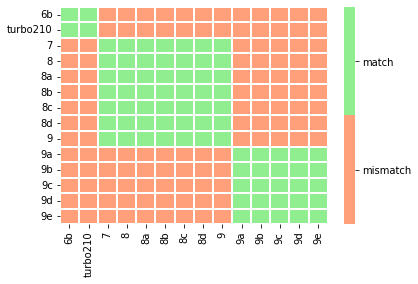

JDCT_IFAST


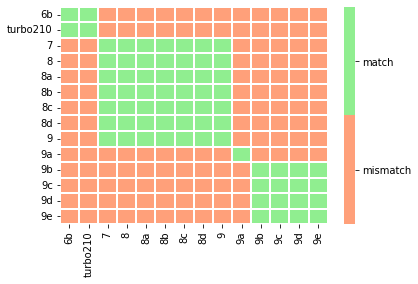

JDCT_FLOAT


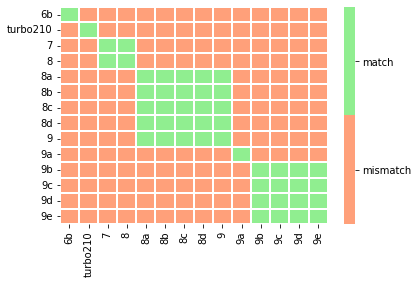

In [43]:
# create plot
import seaborn as sns
for dct_method in dct_methods:
    fig,ax = plt.subplots(1,1)
    sns.heatmap(
        pd.DataFrame(distmats_rgb_samp[dct_method] == 0, index=versions, columns=versions),
        linewidth=.05, ax=ax, cmap=['lightsalmon','lightgreen'])
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
    colorbar.set_ticklabels(['mismatch','match'])
    print(dct_method)
    plt.show();

## Colored without downsampling

Next we check ther differences, when no downsampling is used.

In [44]:
# images recompressed by each version
images_rgb = {'version': [], 'dct_method': [], 'Y': [], 'Cb': [], 'Cr': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate dct methods
        for dct_method in dct_methods:
            
            # compress each image with single (arbitrary) version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
            with jpeglib.version(v_arbitrary):
                for i,fname in enumerate(fnames):
                    im = jpeglib.from_spatial(alaska[i])
                    im.samp_factor = ((1,1),(1,1),(1,1))
                    im.write_spatial(fname, qt=75)
                    
            # decompress with each version
            with jpeglib.version(v_decompress):
                images_rgb['version'].append(v_decompress)
                images_rgb['dct_method'].append(dct_method)
                images_rgb['image'].append(np.array([
                    jpeglib.read_spatial(fname, dct_method=dct_method).spatial for fname in fnames
                ]))
                images_rgb['Y'].append([
                    jpeglib.read_dct(fname).Y for fname in fnames
                ])
                images_rgb['Cb'].append([
                    jpeglib.read_dct(fname).Cb for fname in fnames
                ])
                images_rgb['Cr'].append([
                    jpeglib.read_dct(fname).Cr for fname in fnames
                ])
# dataframe
import pandas as pd
images_rgb = pd.DataFrame(images_rgb)

### N-to-N comparison

In [45]:
# images to distance matrix
distmats_rgb = {}
distmats_Y = {}
distmats_Cb = {}
distmats_Cr = {}
for dct_method in dct_methods:
    images_rgb_dct = images_rgb[images_rgb.dct_method == dct_method]
    
    images_rgb_list = np.array([list(i) for i in images_rgb_dct.image.to_list()])
    images_rgb_list = images_rgb_list.reshape(len(versions), -1)
    dists_rgb = pdist(images_rgb_list, pixel_mismatch)
    distmats_rgb[dct_method] = squareform(dists_rgb)
    
    #distmats_Y[dct_method] = get_distmat_dct(images_rgb.Y)
    #distmats_Cb[dct_method] = get_distmat_dct(images_rgb.Cb)
    #distmats_Cr[dct_method] = get_distmat_dct(images_rgb.Cr)
    
    print(dct_method)
    #print("-", ((distmat_rgb == 0) == (distmats_Y[dct_method] == 0)).all())
    #print("-", ((distmat_rgb == 0) == (distmats_Cb[dct_method] == 0)).all())
    #print("-", ((distmat_rgb == 0) == (distmats_Cr[dct_method] == 0)).all())

JDCT_ISLOW
JDCT_IFAST
JDCT_FLOAT


### Clustering of spatial

In [46]:
# cluster
for dct_method in dct_methods:
    distmat_rgb = distmats_rgb[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_rgb)
        
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_rgb[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
        
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 2 classes: ['9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9']
JDCT_IFAST 3 classes: ['9b', '9c', '9d', '9e'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9'] ['9a']
JDCT_FLOAT 4 classes: ['9b', '9c', '9d', '9e'] ['6b', '7', '8'] ['turbo210', '8a', '8b', '8c', '8d', '9'] ['9a']


### Clustering of DCT

In [47]:
## cluster
#for dct_method in dct_methods:
#    distmat_Cr_d = distmats_Cr_d[dct_method]
#    for k in range(1,6):
#        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
#        agnes.fit(distmat_Cr_d)
        
#        # compute heterogenity metric (sum of distances)
#        heterogenity = np.sum([ distmat_Cr_d[i,j]
#                 for group in np.unique(agnes.labels_)
#                 for i in np.where(agnes.labels_ == group)[0]
#                 for j in np.where(agnes.labels_ == group)[0] ])
        
#        # homogenous clusters
#        if heterogenity == 0: break
#    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

Let's try with colored images with downsampling. Note that there is already described difference in downsampling such that 6b and turbo differ from version 7 and above. 

## Grayscale

Let's start with grayscale. We know that there is no difference in decompression with default parameters and that is what we expect now.

In [48]:
# images recompressed by each version
images_gray = {'version': [], 'dct_method': [],'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # iterate methods
        for dct_method in dct_methods:
            
            # compress with single (arbitrary) version
            fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(boss.shape[0])]
            with jpeglib.version(v_arbitrary):
                [jpeglib.from_spatial(boss[i], 'JCS_GRAYSCALE').write_spatial(fname, qt=75)
                     for i,fname in enumerate(fnames)]
        
            # decompress with each version
            with jpeglib.version(v_decompress):
                images_gray['version'].append(v_decompress)
                images_gray['dct_method'].append(dct_method)
                images_gray['image'].append(np.array([
                    jpeglib.read_spatial(fname, dct_method=dct_method).spatial for fname in fnames
                ]))

# dataframe
import pandas as pd
images_gray = pd.DataFrame(images_gray)

NameError: name 'boss' is not defined

### N-to-N comparison

In [17]:
# images to distance matrix
distmats_gray = {}
for dct_method in dct_methods:
    images_gray_dct = images_gray[images_gray.dct_method == dct_method]
    
    images_gray_list = np.array([list(i) for i in images_gray_dct.image.to_list()])
    images_gray_list = images_gray_list.reshape(len(versions), -1)
    dists_gray = pdist(images_gray_list, pixel_mismatch)
    distmats_gray[dct_method] = squareform(dists_gray)
    
    #distmats_Y[dct_method] = get_distmat_dct(images_rgb.Y)
    #distmats_Cb[dct_method] = get_distmat_dct(images_rgb.Cb)
    #distmats_Cr[dct_method] = get_distmat_dct(images_rgb.Cr)
    
    print(dct_method)
    #print("-", ((distmat_rgb == 0) == (distmats_Y[dct_method] == 0)).all())
    #print("-", ((distmat_rgb == 0) == (distmats_Cb[dct_method] == 0)).all())
    #print("-", ((distmat_rgb == 0) == (distmats_Cr[dct_method] == 0)).all())

JDCT_ISLOW
JDCT_IFAST
JDCT_FLOAT


### Clustering of spatial

In [18]:
# cluster
for dct_method in dct_methods:
    distmat_gray = distmats_gray[dct_method]
    for k in range(1,6):
        agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
        agnes.fit(distmat_gray)
        
        # compute heterogenity metric (sum of distances)
        heterogenity = np.sum([ distmat_gray[i,j]
                 for group in np.unique(agnes.labels_)
                 for i in np.where(agnes.labels_ == group)[0]
                 for j in np.where(agnes.labels_ == group)[0] ])
        
        # homogenous clusters
        if heterogenity == 0: break
    print(dct_method, k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

JDCT_ISLOW 1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']
JDCT_IFAST 2 classes: ['9b', '9c', '9d', '9e'] ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a']
JDCT_FLOAT 3 classes: ['turbo210', '8a', '8b', '8c', '8d', '9', '9a'] ['6b', '7', '8'] ['9b', '9c', '9d', '9e']
